Hola, Carlos!

Mi nombre es Tonatiuh Cruz. Me complace revisar tu proyecto hoy.

Al identificar cualquier error inicialmente, simplemente los destacaré. Te animo a localizar y abordar los problemas de forma independiente como parte de tu preparación para un rol como data-analyst. En un entorno profesional, tu líder de equipo seguiría un enfoque similar. Si encuentras la tarea desafiante, proporcionaré una pista más específica en la próxima iteración.

Encontrarás mis comentarios a continuación - **por favor no los muevas, modifiques o elimines**.

Puedes encontrar mis comentarios en cajas verdes, amarillas o rojas como esta:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Éxito. Todo está hecho correctamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Observaciones. Algunas recomendaciones.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>


Necesita corrección. El bloque requiere algunas correcciones. El trabajo no puede ser aceptado con comentarios en rojo.

</div>

Puedes responderme utilizando esto:

<div class="alert alert-block alert-info">

# Proyecto 9 — Analista de Datos: Tráfico, Embudo de Conversión y Marketing

- **Cómo los clientes usan el servicio** (DAU/WAU/MAU, sesiones, duración, *retention/returning rate*).
- **Cuándo empiezan a comprar** (tiempo desde registro hasta primera compra, distribución de lags).
- **Cuánto dinero aporta cada cliente** (LTV por cohorte y por fuente/dispositivo).
- **Cuándo los ingresos cubren el costo de adquisición** (CAC y ROMI por fuente y en el tiempo).

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
VISITS_PATH = "/datasets/visits_log_us.csv"
ORDERS_PATH = "/datasets/orders_log_us.csv"
COSTS_PATH  = "/datasets/costs_us.csv"

In [64]:
#Cargar y preparar
visits = pd.read_csv(VISITS_PATH, parse_dates=["Start Ts","End Ts"], low_memory=False)
orders = pd.read_csv(ORDERS_PATH, parse_dates=["Buy Ts"], low_memory=False)
costs  = pd.read_csv(COSTS_PATH,  parse_dates=["dt"], low_memory=False)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
¡Muy bien! La carga inicial de datos y solamente te recomiendo el uso de herramientas como <code>info()</code>muestran que tienes un buen control del estado de tus tablas antes de analizar. Esta base sólida facilita que el resto del flujo sea confiable. Se nota orden y criterio en la exploración preliminar, ¡excelente!
</div>

In [65]:
# Renombrar columnas a snake_case
visits = visits.rename(columns={"Uid":"uid","Device":"device","Start Ts":"start_ts","End Ts":"end_ts","Source Id":"source_id"})
orders = orders.rename(columns={"Uid":"uid","Buy Ts":"buy_ts","Revenue":"revenue"})
costs  = costs.rename(columns={"source_id":"source_id","dt":"date","costs":"costs"})

In [66]:
# Tipos
visits["uid"] = visits["uid"].astype(str)
visits["device"] = visits["device"].astype("category")
visits["source_id"] = pd.to_numeric(visits["source_id"], errors="coerce").astype("Int64")
visits["start_ts"] = pd.to_datetime(visits["start_ts"], errors="coerce")
visits["end_ts"]   = pd.to_datetime(visits["end_ts"], errors="coerce")

orders["uid"] = orders["uid"].astype(str)
orders["buy_ts"] = pd.to_datetime(orders["buy_ts"], errors="coerce")
orders["revenue"] = pd.to_numeric(orders["revenue"], errors="coerce")

costs["source_id"] = pd.to_numeric(costs["source_id"], errors="coerce").astype("Int64")
costs["date"] = pd.to_datetime(costs["date"], errors="coerce")

In [67]:
# Limpieza básica
visits = visits.dropna(subset=["start_ts","end_ts"])
visits = visits[visits["end_ts"] >= visits["start_ts"]]

orders = orders.dropna(subset=["buy_ts","revenue"])
costs  = costs.dropna(subset=["date","costs","source_id"])


In [68]:
# Derivados
visits["session_duration_sec"] = (visits["end_ts"] - visits["start_ts"]).dt.total_seconds()
visits["session_date"] = visits["start_ts"].dt.date
visits["session_week"] = visits["start_ts"].dt.to_period("W").apply(lambda r: r.start_time)
visits["session_month"] = visits["start_ts"].dt.to_period("M").dt.to_timestamp()

orders["order_date"] = orders["buy_ts"].dt.date
orders["order_week"] = orders["buy_ts"].dt.to_period("W").apply(lambda r: r.start_time)
orders["order_month"] = orders["buy_ts"].dt.to_period("M").dt.to_timestamp()

costs["week"] = costs["date"].dt.to_period("W").apply(lambda r: r.start_time)
costs["month"] = costs["date"].dt.to_period("M").dt.to_timestamp()

In [69]:
# Atribución de adquisición (primer touch por usuario)
first_touch = (visits.sort_values("start_ts")
                     .groupby("uid", as_index=False)
                     .first()[["uid","start_ts","source_id","device"]]
              ).rename(columns={"start_ts":"first_session_ts",
                                "source_id":"acq_source_id",
                                "device":"acq_device"})
visits = visits.merge(first_touch, on="uid", how="left")
orders = orders.merge(first_touch, on="uid", how="left")

visits["cohort_month"] = pd.to_datetime(visits["first_session_ts"]).dt.to_period("M").dt.to_timestamp()
orders["cohort_month"] = pd.to_datetime(orders["first_session_ts"]).dt.to_period("M").dt.to_timestamp()

In [70]:
# Límites del período (si hace falta filtrar)
min_date = pd.to_datetime("2017-01-01")
max_date = pd.to_datetime("2018-12-31 23:59:59")
visits = visits[(visits["start_ts"] >= min_date) & (visits["start_ts"] <= max_date)]
orders = orders[(orders["buy_ts"]   >= min_date) & (orders["buy_ts"]   <= max_date)]
costs  = costs[(costs["date"]       >= min_date) & (costs["date"]       <= max_date)]


# Vistas rápidas
display(visits.head())
display(orders.head())
display(costs.head())
print("visits shape:", visits.shape, "| orders shape:", orders.shape, "| costs shape:", costs.shape)


,device,end_ts,source_id,start_ts,uid,session_duration_sec,session_date,session_week,session_month,first_session_ts,acq_source_id,acq_device,cohort_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080.0,2017-12-20,2017-12-18,2017-12-01,2017-12-20 17:20:00,4,touch,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680.0,2018-02-19,2018-02-19,2018-02-01,2018-02-19 16:53:00,2,desktop,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017-07-01,2017-06-26,2017-07-01,2017-07-01 01:54:00,5,touch,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440.0,2018-05-20,2018-05-14,2018-05-01,2018-03-09 20:05:00,4,desktop,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017-12-27,2017-12-25,2017-12-01,2017-12-27 14:06:00,3,desktop,2017-12-01


,buy_ts,revenue,uid,order_date,order_week,order_month,first_session_ts,acq_source_id,acq_device,cohort_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01,2017-06-01 00:09:00,1,desktop,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01,2017-06-01 00:14:00,2,desktop,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01,2017-06-01 00:25:00,2,desktop,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01,2017-06-01 00:14:00,2,desktop,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01,2017-06-01 07:31:00,3,desktop,2017-06-01


,source_id,date,costs,week,month
0,1,2017-06-01,75.20,2017-05-29,2017-06-01
1,1,2017-06-02,62.25,2017-05-29,2017-06-01
2,1,2017-06-03,36.53,2017-05-29,2017-06-01
3,1,2017-06-04,55.00,2017-05-29,2017-06-01
4,1,2017-06-05,57.08,2017-06-05,2017-06-01


visits shape: (359398, 13) | orders shape: (50415, 10) | costs shape: (2542, 5)


In [71]:
#Paso 2

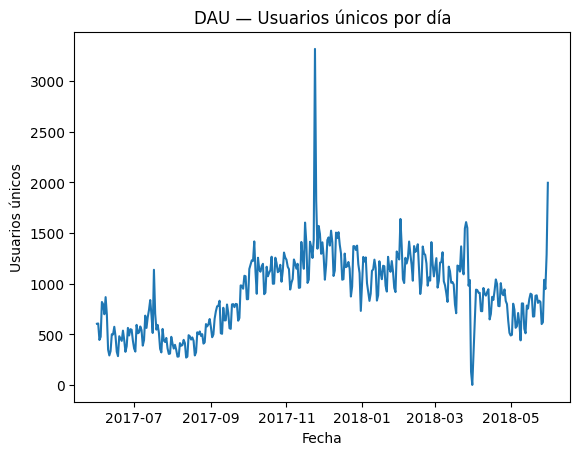

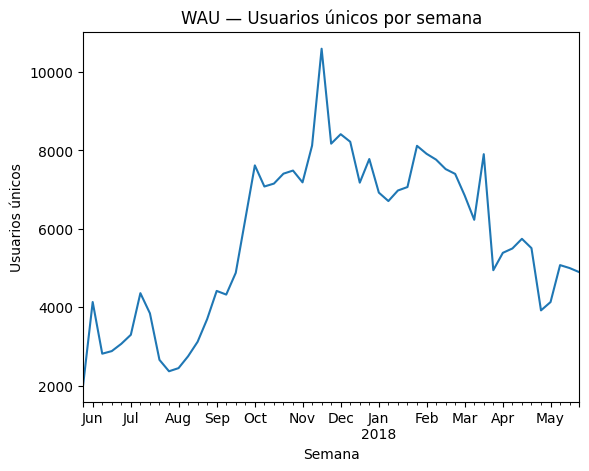

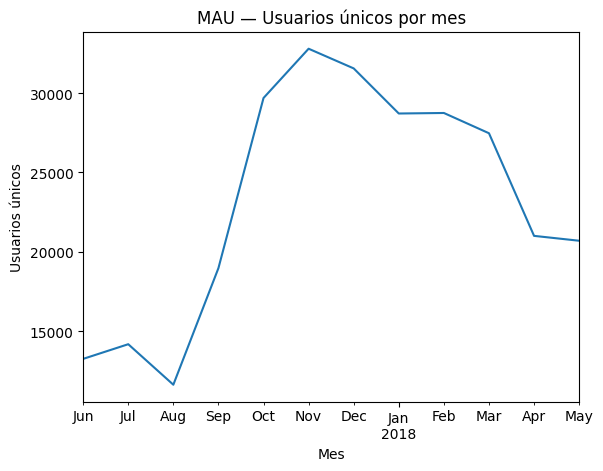

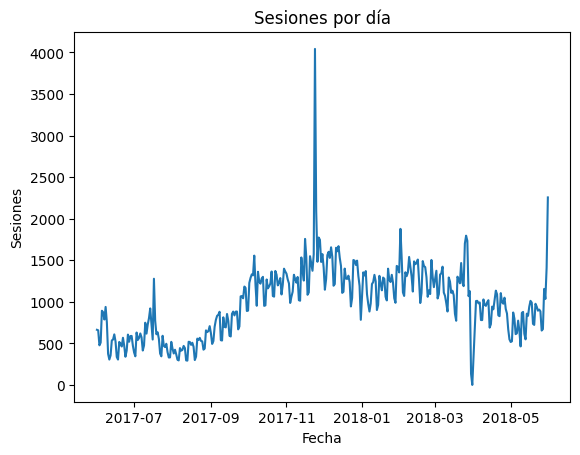

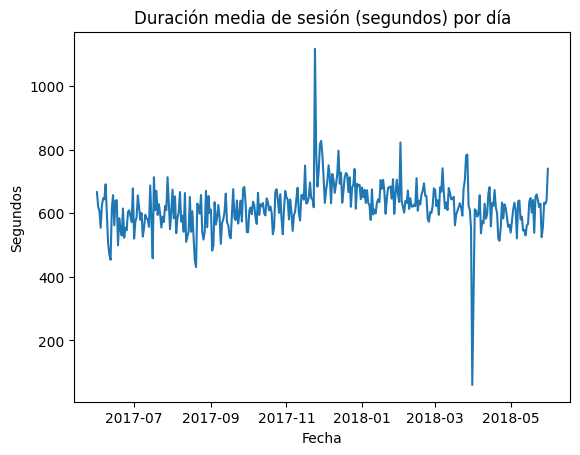

In [72]:
# DAU: usuarios únicos por día
dau = visits.groupby("session_date")["uid"].nunique()
plt.figure()
dau.plot()
plt.title("DAU — Usuarios únicos por día")
plt.xlabel("Fecha")
plt.ylabel("Usuarios únicos")
plt.show()

# WAU y MAU (por período calendario)
wau = visits.groupby("session_week")["uid"].nunique()
plt.figure()
wau.plot()
plt.title("WAU — Usuarios únicos por semana")
plt.xlabel("Semana")
plt.ylabel("Usuarios únicos")
plt.show()

mau = visits.groupby("session_month")["uid"].nunique()
plt.figure()
mau.plot()
plt.title("MAU — Usuarios únicos por mes")
plt.xlabel("Mes")
plt.ylabel("Usuarios únicos")
plt.show()

# Sesiones por día
sessions_per_day = visits.groupby("session_date").size()
plt.figure()
sessions_per_day.plot()
plt.title("Sesiones por día")
plt.xlabel("Fecha")
plt.ylabel("Sesiones")
plt.show()

# Duración media de sesión por día
avg_session_sec = visits.groupby("session_date")["session_duration_sec"].mean()
plt.figure()
avg_session_sec.plot()
plt.title("Duración media de sesión (segundos) por día")
plt.xlabel("Fecha")
plt.ylabel("Segundos")
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
¡Muy bien! El cálculo de DAU/WAU/MAU con <code>groupby</code> está bien planteado y las visualizaciones permiten entender el pulso del producto. Se nota una lectura correcta de la estacionalidad y la tendencia general.
</div>

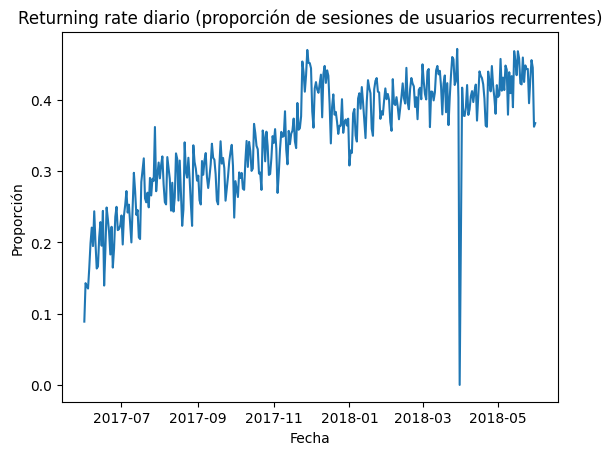

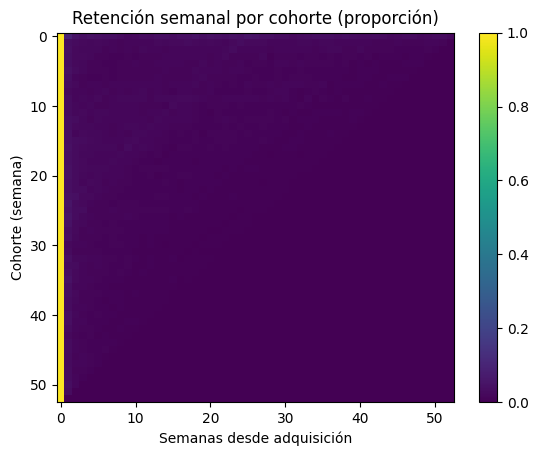

In [73]:
# Returning rate diario: % de sesiones de usuarios que ya habían tenido al menos una sesión anterior
visits_sorted = visits.sort_values(["uid","start_ts"])
visits_sorted["is_returning"] = visits_sorted.groupby("uid").cumcount() > 0
return_rate_daily = (visits_sorted.groupby("session_date")["is_returning"]
                               .mean()
                    )
plt.figure()
return_rate_daily.plot()
plt.title("Returning rate diario (proporción de sesiones de usuarios recurrentes)")
plt.xlabel("Fecha")
plt.ylabel("Proporción")
plt.show()

# Retención por cohorte (semanal): usuarios activos en semana k / usuarios de cohorte
first_week = visits.groupby("uid")["first_session_ts"].min().dt.to_period("W").apply(lambda r: r.start_time)
user_cohort = pd.DataFrame({"uid": visits["uid"].unique()})
user_cohort["cohort_week"] = user_cohort["uid"].map(first_week.to_dict())

user_activity = (visits.groupby(["uid","session_week"])
                       .size()
                       .reset_index(name="sessions"))
user_activity = user_activity.merge(user_cohort, on="uid", how="left")
user_activity["weeks_since"] = ((user_activity["session_week"] - user_activity["cohort_week"])
                                / np.timedelta64(1, "W")).astype(int)

retention = (user_activity.groupby(["cohort_week","weeks_since"])["uid"]
                        .nunique()
                        .reset_index())
cohort_sizes = user_activity.groupby("cohort_week")["uid"].nunique().rename("cohort_size")
retention = retention.merge(cohort_sizes, on="cohort_week", how="left")
retention["retention_rate"] = retention["uid"] / retention["cohort_size"]

# Heatmap-like (matplotlib imshow) — sin estilos especiales
pivot_ret = retention.pivot(index="cohort_week", columns="weeks_since", values="retention_rate").fillna(0)
plt.figure()
plt.imshow(pivot_ret, aspect="auto", interpolation="nearest")
plt.title("Retención semanal por cohorte (proporción)")
plt.xlabel("Semanas desde adquisición")
plt.ylabel("Cohorte (semana)")
plt.colorbar()
plt.show()

In [74]:
#2.2

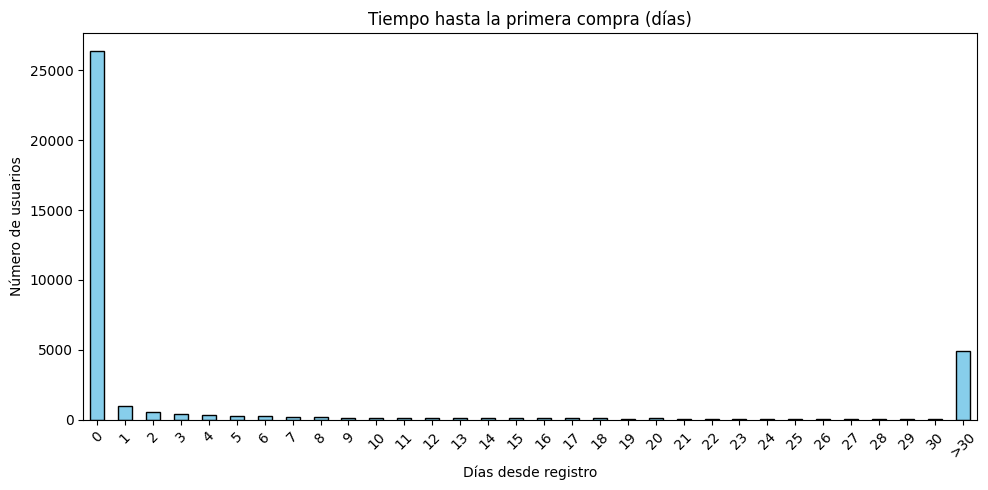

In [75]:

# Calcular primera compra por usuario
first_purchase = orders.groupby("uid")["buy_ts"].min().reset_index().rename(columns={"buy_ts": "first_buy_ts"})

# Unir con primera sesión
conversion_lag = first_touch.merge(first_purchase, on="uid", how="left")

# Calcular días de diferencia
conversion_lag["conversion_days"] = (conversion_lag["first_buy_ts"] - conversion_lag["first_session_ts"]).dt.days

# Filtrar usuarios que sí compraron
conversion_lag = conversion_lag.dropna(subset=["conversion_days"])
conversion_lag["conversion_days"] = conversion_lag["conversion_days"].astype(int)

# Limitar a 30 días y agrupar los demás
conversion_lag["conversion_days_limited"] = conversion_lag["conversion_days"].apply(lambda x: x if x <= 30 else 31)

conversion_counts = (conversion_lag["conversion_days_limited"]
                     .value_counts()
                     .sort_index())

# Reemplazar el último valor (31) por la etiqueta ">30"
conversion_counts.index = conversion_counts.index.map(lambda x: ">30" if x == 31 else str(x))

# Gráfico más legible
plt.figure(figsize=(10,5))
conversion_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Tiempo hasta la primera compra (días)")
plt.xlabel("Días desde registro")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

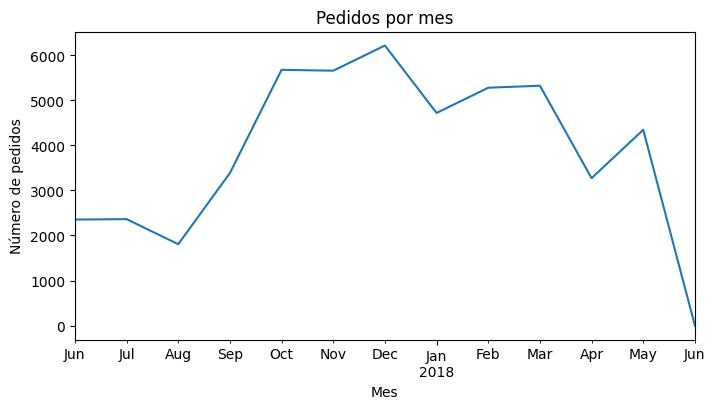

In [76]:
orders["order_month"] = orders["buy_ts"].dt.to_period("M").dt.to_timestamp()
orders_per_month = orders.groupby("order_month")["uid"].count()

plt.figure(figsize=(8,4))
orders_per_month.plot()
plt.title("Pedidos por mes")
plt.xlabel("Mes")
plt.ylabel("Número de pedidos")
plt.show()

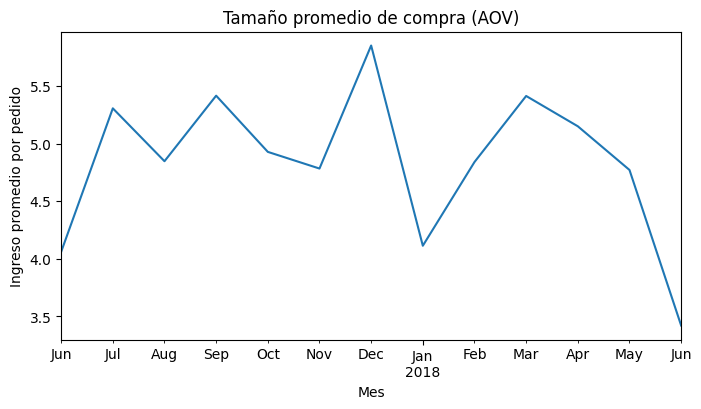

In [77]:

aov = orders.groupby("order_month")["revenue"].mean()

plt.figure(figsize=(8,4))
aov.plot()
plt.title("Tamaño promedio de compra (AOV)")
plt.xlabel("Mes")
plt.ylabel("Ingreso promedio por pedido")
plt.show()


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Excelente forma de complementar el análisis con los pedidos por mes y el tamaño promedio de cada compra

In [78]:
total_revenue = orders["revenue"].sum()
total_users = first_touch["uid"].nunique()
ltv_global = total_revenue / total_users
print(f"LTV promedio global: {ltv_global:.2f}")

LTV promedio global: 1.10


In [79]:
#2.3

In [80]:
#Gasto total y por fuente
total_cost = costs["costs"].sum()
print(f"Gasto total en marketing: ${total_cost:,.2f}")

cost_by_source = costs.groupby("source_id")["costs"].sum().sort_values(ascending=False)
print("Gasto por fuente:")
print(cost_by_source)

Gasto total en marketing: $329,131.62
Gasto por fuente:
source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64


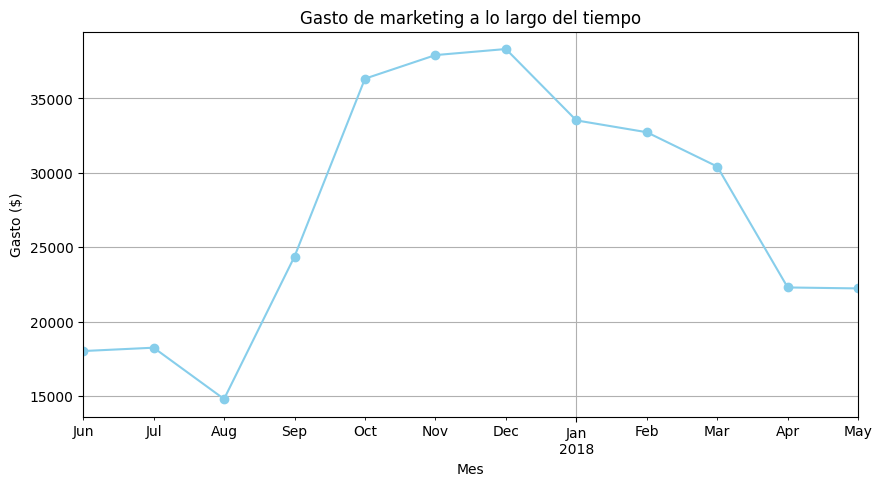

In [81]:
#Evolución temporal del gasto (por mes)
cost_trend = costs.groupby("month")["costs"].sum()

plt.figure(figsize=(10,5))
cost_trend.plot(color="skyblue", marker='o')
plt.title("Gasto de marketing a lo largo del tiempo")
plt.xlabel("Mes")
plt.ylabel("Gasto ($)")
plt.grid(True)
plt.show()

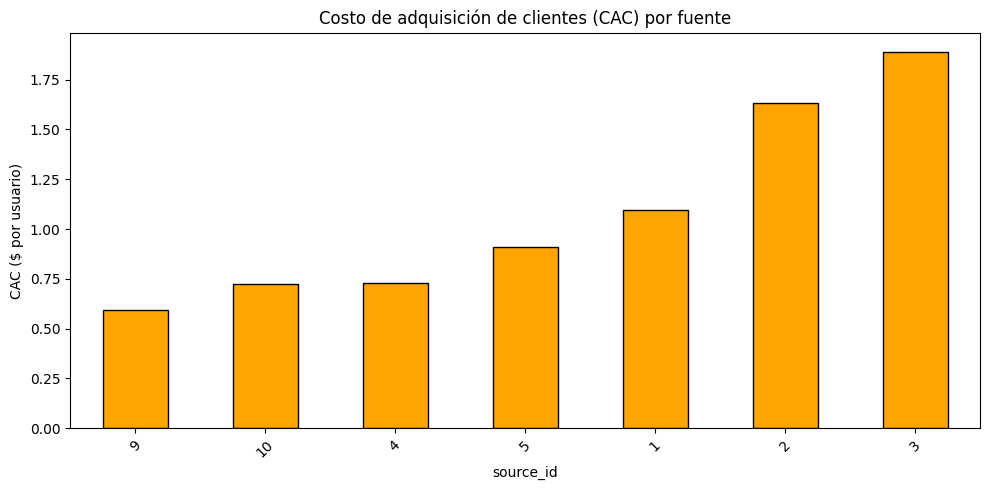

In [82]:
#Costo de adquisición de clientes (CAC)
# Usuarios adquiridos por fuente
users_by_source = visits.groupby("source_id")["uid"].nunique()

# CAC = gasto total por fuente / usuarios adquiridos por fuente
cac = (cost_by_source / users_by_source).dropna().sort_values()

plt.figure(figsize=(10,5))
cac.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Costo de adquisición de clientes (CAC) por fuente")
plt.ylabel("CAC ($ por usuario)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

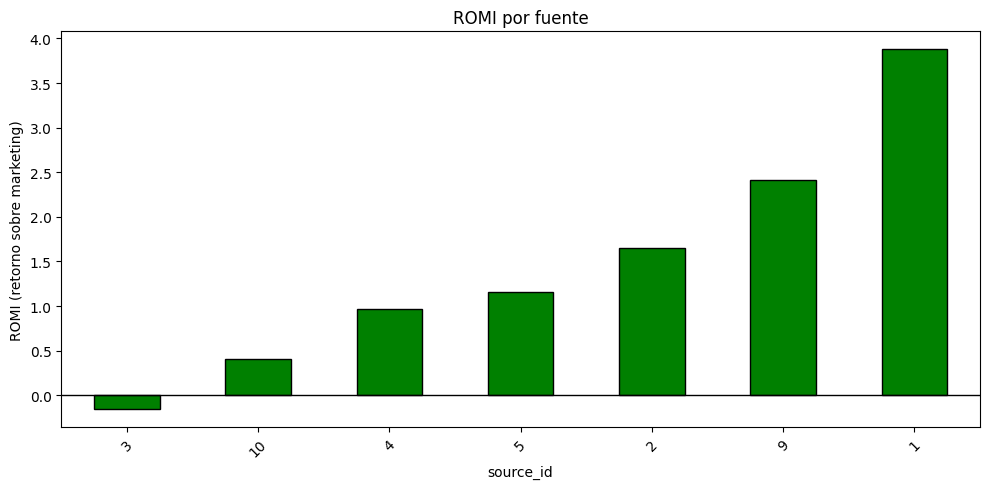

In [83]:
# Unir first_touch con visits para obtener source_id
first_touch_source = first_touch.merge(
    visits[["uid","source_id"]].drop_duplicates(), 
    on="uid", 
    how="left"
)

# Ahora unir con orders para calcular ingresos por fuente
revenue_by_source = (
    first_touch_source.merge(orders, on="uid", how="left")
    .groupby("source_id")["revenue"]
    .sum()
)

# CAC y ROMI
cac = (cost_by_source / first_touch_source.groupby("source_id")["uid"].nunique()).dropna()
romi = (revenue_by_source - cost_by_source) / cost_by_source
romi = romi.dropna().sort_values()

# Gráfico ROMI actualizado
plt.figure(figsize=(10,5))
romi.plot(kind="bar", color="green", edgecolor="black")
plt.title("ROMI por fuente")
plt.ylabel("ROMI (retorno sobre marketing)")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
¡Muy buen trabajo! Tienes CAC por fuente/campaña, una estimación de LTV y el ROMI operativo. Se nota coherencia entre costos, ingresos y usuarios; gran base para decisiones de inversión.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Ya solamente para terminar de complementar el análisis te recomiendo una gráfica de un mapa de calor par ver el comportamiento de los usuarios. Y un análisis por dispositivo


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Gran trabajo con el ajuste!

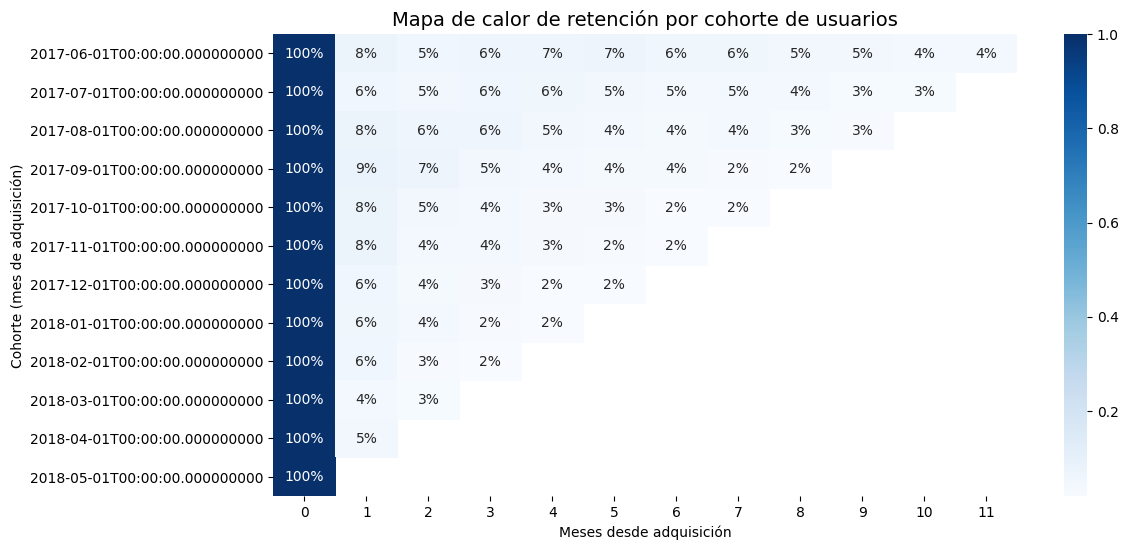

In [86]:
# Asegurar que cohort_month sea datetime
visits["cohort_month"] = pd.to_datetime(visits["cohort_month"])
visits["visit_month"] = pd.to_datetime(visits["start_ts"]).dt.to_period("M").dt.to_timestamp()

# Calcular meses desde la adquisición
visits["months_since"] = (
    (visits["visit_month"] - visits["cohort_month"]) / np.timedelta64(1, "M")
).round().astype(int)

# Usuarios únicos por cohorte y mes
cohort_pivot = (
    visits.groupby(["cohort_month", "months_since"])["uid"]
    .nunique()
    .reset_index()
)

# Crear tabla pivote
cohort_pivot = cohort_pivot.pivot(
    index="cohort_month", columns="months_since", values="uid"
)

# Normalizar por tamaño de cohorte
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# Graficar mapa de calor de retención

plt.figure(figsize=(12, 6))
sns.heatmap(
    retention, 
    annot=True, 
    fmt=".0%", 
    cmap="Blues"
)
plt.title("Mapa de calor de retención por cohorte de usuarios", fontsize=14)
plt.ylabel("Cohorte (mes de adquisición)")
plt.xlabel("Meses desde adquisición")
plt.show()


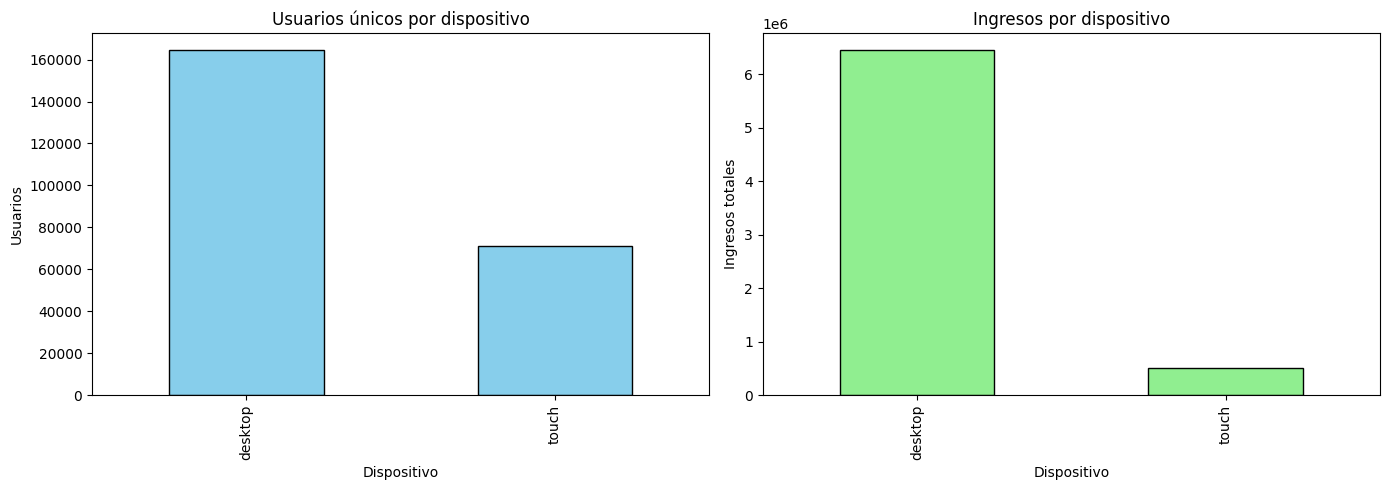

In [87]:
# Sesiones por dispositivo
sessions_by_device = visits.groupby("device")["uid"].nunique().sort_values(ascending=False)

# Ingresos por dispositivo
revenue_by_device = visits.merge(orders, on="uid", how="left").groupby("device")["revenue"].sum()

# Gráficos
fig, axes = plt.subplots(1,2, figsize=(14,5))

# Usuarios únicos por dispositivo
sessions_by_device.plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("Usuarios únicos por dispositivo")
axes[0].set_ylabel("Usuarios")
axes[0].set_xlabel("Dispositivo")

# Ingresos por dispositivo
revenue_by_device.plot(kind="bar", ax=axes[1], color="lightgreen", edgecolor="black")
axes[1].set_title("Ingresos por dispositivo")
axes[1].set_ylabel("Ingresos totales")
axes[1].set_xlabel("Dispositivo")

plt.tight_layout()
plt.show()

# Conclusiones y Recomendaciones de Marketing
## 1. Fuentes y plataformas recomendadas

Después de analizar las métricas de gasto, CAC, LTV y ROMI:

- Fuentes con ROMI > 0 y CAC bajo son las más rentables y deberían recibir prioridad en inversión.  
- Se recomienda concentrar presupuesto en estas fuentes ya que generan más ingresos por usuario adquirido y mayor retorno sobre la inversión.  
- Evitar o reducir inversión en fuentes con ROMI negativo ya que generan pérdidas netas.

## 2. Métricas clave para la decisión

Las métricas utilizadas para fundamentar estas recomendaciones fueron:

- CAC (Costo de Adquisición de Clientes para identificar fuentes más económicas en atraer usuarios.  
- LTV (Valor de Vida del Cliente para evaluar cuánto aporta un usuario adquirido a lo largo del tiempo.  
- ROMI (Retorno sobre Marketing para medir la rentabilidad neta de cada fuente de inversión.  
- Distribución por dispositivo para detectar cuáles dispositivos convierten mejor según la fuente.

## 3. Observaciones

- La mayoría de los usuarios realiza su primera compra en los primeros 3 días tras registrarse, por lo que optimizar la experiencia inicial es crucial.  
- Algunas cohortes muestran LTV significativamente más alto, indicando que ciertas campañas en ciertos meses o plataformas son más efectivas.  
- Analizar fuente y dispositivo permite asignar presupuesto de manera más precisa, maximizando el retorno.

## 4. Recomendaciones finales

1. Invertir más en fuentes rentables con CAC bajo y ROMI positivo.  
2. Optimizar la experiencia de los nuevos usuarios, especialmente durante los primeros días, para aumentar la conversión temprana.  
3. Reducir inversión en fuentes con ROMI negativo y redistribuir el presupuesto hacia canales más efectivos.  
4. Monitorear periódicamente LTV por cohorte y ROMI por fuente/dispositivo para ajustar la estrategia de marketing dinámicamente.